In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

def process_clonotypes_with_umi(folder_path, output_file):
    # List to hold all clonotype data with filename, count, and TotalUMI
    all_clonotype_data = []

    # Traverse through all files in the folder and subfolders
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith("IGH.tsv"):  # Process only .tsv files
                file_path = os.path.join(root, filename)
                print(f"Processing file: {file_path}")

                # Load the TSV file
                data = pd.read_csv(file_path, sep='\t')

                # Check if required columns exist
                if 'aaSeqCDR3' in data.columns and 'uniqueMoleculeCount' in data.columns:
                    # Convert 'uniqueMoleculeCount' to numeric, coercing errors to NaN
                    data['uniqueMoleculeCount'] = pd.to_numeric(data['uniqueMoleculeCount'], errors='coerce')

                    # Drop rows with missing values in the required columns
                    filtered_data = data[['aaSeqCDR3', 'uniqueMoleculeCount']].dropna()

                    # Group by Clonotype (aaSeqCDR3) and calculate Count and TotalUMI
                    grouped = filtered_data.groupby('aaSeqCDR3').agg(
                        Count=('aaSeqCDR3', 'size'),
                        TotalUMI=('uniqueMoleculeCount', 'sum')
                    ).reset_index()

                    # Add the filename column
                    grouped['Filename'] = filename

                    # Append to the overall data list
                    all_clonotype_data.append(grouped)
                else:
                    print(f"Warning: Required columns ('aaSeqCDR3', 'uniqueMoleculeCount') not found in {filename}")

    # Concatenate all results into a single DataFrame
    if all_clonotype_data:
        result_df = pd.concat(all_clonotype_data, ignore_index=True)
        result_df.rename(columns={'aaSeqCDR3': 'Clonotype'}, inplace=True)

        # Reorder columns for clarity
        result_df = result_df[['Filename', 'Clonotype', 'Count', 'TotalUMI']]

        # Save the result to a CSV file
        result_df.to_csv(output_file, index=False)
        print(f"Clonotype data saved to {output_file}")

    return result_df if all_clonotype_data else None


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_total_umi_distribution(data, output_png):
    """
    This function takes a DataFrame containing clonotype data and generates a line plot
    for the total UMI distribution based on experiment patterns (Exp2/Exp3).
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    output_png (str): Path to save the output PNG file.
    """
    # Check for experiment type based on filenames
    unique_filenames = data['Filename'].unique()

    # Define the patterns based on the filenames
    if any("Exp2" in fn for fn in unique_filenames):
        patterns = ["MME", "D1", "D2", "D3", "D4", "D5", "PBMC"]
    elif any("Exp3" in fn for fn in unique_filenames):
        patterns = ["MMC", "D1", "D2", "D3", "D4", "D5", "PBMC"]
    else:
        patterns = ["MME", "D1", "D2", "D3", "D4", "D5", "PBMC"]  # Default patterns

    # Create subplots: 1 row, one column per pattern
    nrows = 1
    ncols = len(patterns)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3), squeeze=False)

    # Group data by 'Filename'
    grouped = data.groupby('Filename')

    # Custom formatter for y-axis (in thousands)
    # formatter = FuncFormatter(lambda y, _: f"${y / 1e3:.2f}$" if y > 0 else "0")
    
    # formtter for making the y axis a log scale
    formatter = FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$" if y > 0 else "0")

    # Iterate over each file and plot in the appropriate subplot
    for filename, group in grouped:
        matched_pattern = next((p for p in patterns if p in filename), None)
        
        if matched_pattern is None:
            continue

        # Sort data by 'TotalUMI' in descending order
        sorted_group = group.sort_values(by='TotalUMI', ascending=False).reset_index(drop=True)
        
        # Get x and y values for plotting
        x_values = sorted_group.index
        y_values = sorted_group['TotalUMI']
        
        # Determine the axis based on the matched pattern
        col_index = patterns.index(matched_pattern)
        ax = axes[0, col_index]  # Adjusted for 2D array indexing

        # Plot the data
        ax.plot(x_values, y_values, linewidth=2, alpha=0.8, label=filename)
        ax.fill_between(x_values, y_values, alpha=0.2)

        # Use a logarithmic scale for x-axis
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(formatter)

        # Set labels and formatting
        ax.set_title(matched_pattern, fontsize=14)
        # ax.set_ylabel('Total unique UMI\n(thousands)', fontsize=12)
        ax.set_ylabel('Total unique UMI (log)', fontsize=12)
        ax.tick_params(axis='x', rotation=45)

    # Add an overarching title and adjust layout
    plt.suptitle("TotalUMI Distributions by Pattern", fontsize=16, y=1.05)
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_png, dpi=300)
    plt.show()


# Example usage:
# plot_total_umi_distribution('/home/rittika/Workprojects/iRepertoire/clonotypes_with_filenames_and_umi.csv')



# # Define folder path
# folder_path = "IRP-Heavy-RNA/MME"  # Replace with your folder path

# # Generate dynamic output file names based on folder path
# folder_name = os.path.basename(folder_path.rstrip("/\\"))
# output_file = f"{folder_name}_clonotypes_with_filenames_and_umi.csv"
# lineplot_output_png = f"{folder_name}_lineplots.png"
# heatmap_output_png = f"{folder_name}_clonotype_vs_uniqUMI_heatmap.png"

# # Call the function
# result_df = process_clonotypes_with_umi(folder_path, output_file)
# if result_df is not None:
#     plot_total_umi_distribution(output_file, lineplot_output_png)
#     calculate_and_plot_sums(result_df, heatmap_output_png)


def calculate_and_plot_sums(data, output_png, existing_plot=None, marker_color='steelblue', legend_label='Clonotypes'):
    """
    Calculate the sum of 'Count' and 'TotalUMI' per 'Filename' and create a scatter plot
    where each filename is on the x-axis as a category, the y-axis shows total clonotypes,
    and the marker size encodes total UMI. Adds data to the same plot across function calls.
    """
    
    import matplotlib.pyplot as plt
    import numpy as np

    # If no existing plot is provided, create a new figure
    if existing_plot is None:
        existing_plot = plt.figure(figsize=(8, 6))
    
    # Use or create the axes (make sure it's a single axis to add more data)
    ax = existing_plot.gca()

    # Determine the unique filenames
    unique_filenames = data['Filename'].unique()

    # Define the patterns based on the filenames
    if any("Exp2" in fn for fn in unique_filenames):
        patterns = ["MME", "D1", "D2", "D3", "D4","D5", "PBMC"]
    elif any("Exp3" in fn for fn in unique_filenames):
        patterns = ["MMC", "D1", "D2", "D3", "D4","D5", "PBMC"]
    else:
        # Default pattern if neither Exp2 nor Exp3 is found
        patterns = ["MMC", "D2",  "PBMC"]

    # Group by Filename and calculate the sums
    sums = data.groupby('Filename')[['Count', 'TotalUMI']].sum().reset_index()

    # Simplify filenames for x-labels
    sums['SimplifiedName'] = sums['Filename'].apply(lambda x: "_".join(x.split("_")[2:7]))

    # Custom sorting function based on the defined patterns
    def custom_sort(simplified_name):
        for i, pattern in enumerate(patterns):
            if pattern in simplified_name:
                return i
        return len(patterns)  # put any unmatched names at the end

    # Sort the dataframe based on the custom sorting function
    sums['SortOrder'] = sums['SimplifiedName'].apply(custom_sort)
    sums = sums.sort_values(['SortOrder', 'Count'], ascending=[True, True]).reset_index(drop=True)

    # Extract x, y, and UMI values
    x_labels = sums['SimplifiedName']
    x = range(len(x_labels))
    y = sums['Count']
    umi = sums['TotalUMI']

    # Use the TotalUMI to scale marker sizes. Adjust the scaling factor as needed.
    marker_sizes = (umi / umi.max()) * 500  # scale factor for visibility

    # Plot data points on the same figure
    scatter = ax.scatter(x, y, s=marker_sizes, alpha=0.7, c= marker_color, edgecolor='black', vmax=1e3)

    # Set x-ticks to show simplified filenames
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

    # Label axes
    ax.set_xlabel('Filename', fontsize=12)
    ax.set_ylabel('Total Clonotypes', fontsize=12)
    ax.set_title('Clonotypes vs. UMI per Dilution', fontsize=14)

    # # Add a colorbar to show UMI mapping
    # cbar = plt.colorbar(scatter, ax=ax)
    # # cbar.set_label('Total UMI', fontsize=12)

    # Add custom legend (color box with the label passed as parameter)
    color_patch = mpatches.Patch(color=marker_color, label=legend_label)
    # ax.legend(handles=[color_patch], title="Legend", loc='upper left')
    
    # Adjust layout
    plt.tight_layout()

    # Save the plot if required
    if output_png:
        plt.savefig(output_png, dpi=300)

    # Return the existing plot for future updates
    return existing_plot


In [47]:
# # # Initialize the legend_patches list
# # legend_patches = []
# output_file = "DNA_MME_comparison_heavy.csv"
# # First plot
# result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Assay comparison/DNA 500ng assay comparison/Exp2/Heavy/Abh-ILMN", output_file)
# plot_total_umi_distribution(result_df, "DNA_MME_comparison_lineplots_AbHelix.png")

# # Then, process and plot data for the second folder, continuing the same plot
# result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Assay comparison/DNA 500ng assay comparison/Exp2/Heavy/iRepertoire", output_file)
# plot_total_umi_distribution(result_df, "DNA_MME_comparison_lineplots_iRepertoire.png")

# # Process and plot data for the third folder
# result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Assay comparison/DNA 500ng assay comparison/Exp2/Heavy/Cellecta", output_file)
# plot_total_umi_distribution(result_df, "DNA_MME_comparison_lineplots_Cellecta.png")

Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_PBMC_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_D4_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_D2_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_MMC_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_D1_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_D5_CEL_L100_NextSeq2k.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3/MiXCR_IMGT_Exp3_RNA_D3_CEL_L100_NextSeq2k.clones_IGH.

/tmp/ipykernel_17895/4201606088.py:21: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')


Clonotype data saved to Cellecta_heavy_RNA_lineplot.csv


/tmp/ipykernel_17895/4201606088.py:217: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  scatter = ax.scatter(x, y, s=marker_sizes, alpha=0.7, c= marker_color, edgecolor='black', vmax=1e3)


Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_D4_CEL_L100_NextSeq2k_S6_L002.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_D1_CEL_L100_NextSeq2k_S3_L002.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_D5_CEL_L100_NextSeq2k_S7_L002.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_D3_CEL_L100_NextSeq2k_S5_L002.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_MMC_CEL_L100_NextSeq2k_S2_L001.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng/MiXCR_IMGT_Exp3_RNA_PBMC_CEL_L100_NextSeq2k_S1_L002.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Cellecta-re

/tmp/ipykernel_17895/4201606088.py:217: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  scatter = ax.scatter(x, y, s=marker_sizes, alpha=0.7, c= marker_color, edgecolor='black', vmax=1e3)


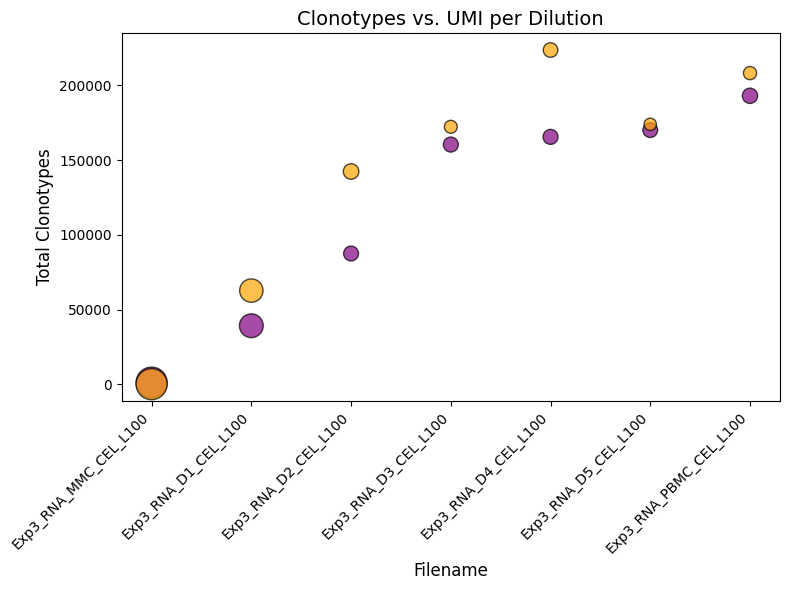

In [50]:
# # Initialize the legend_patches list
# legend_patches = []
output_file = "Cellecta_heavy_RNA_lineplot.csv"
# First plot
result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Cellecta-results/align-reports/Pool1/Exp3", output_file)
plot = calculate_and_plot_sums(result_df, "Cellecta_heavy_RNA_heatmaplot.png", marker_color='Purple', legend_label='AbHelix')

# # Process and plot data for the third folder
# result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Cellecta-results/align-reports/Pool4/single-repeat/RNA", output_file)
# plot = calculate_and_plot_sums(result_df, "Cellecta_heavy_RNA_heatmaplot.png", existing_plot=plot, marker_color='Grey', legend_label='Cellecta')

# Then, process and plot data for the second folder, continuing the same plot
result_df = process_clonotypes_with_umi("/home/rittika/Workprojects/Cellecta-results/align-reports/Pool2/Exp3/100ng", output_file)
plot = calculate_and_plot_sums(result_df, "Cellecta_heavy_RNA_heatmaplot.png", existing_plot=plot, marker_color='Orange', legend_label='iRepertoire')
